In [64]:
import pandas as pd
from tqdm import tqdm

from functions import print_shape, df_security_code

# some example data
import numpy as np

import pandas

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
from tqdm import tqdm_notebook,tqdm
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')



In [65]:
test_data = pd.read_csv('data/curr_test_data.csv', parse_dates=['Date'], index_col=[0])
train_data = pd.read_csv('data/curr_train_data.csv', parse_dates=['Date'], index_col=[0])

In [66]:
test_data.head()

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month_sin,Month_cos,Year_sin,Year_cos,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
1178,20211029_8194,2021-10-29,8194,0.0,0,3760.0,3760.0,3690.0,3735.0,74600.0,...,0.897735,-0.440535,-0.888593,0.458696,1.078200e+10,3.870930e+11,2.785377,77.71551,102.7546,-12.349456
1179,20211101_8194,2021-11-01,8194,0.0,0,3800.0,3805.0,3680.0,3725.0,205800.0,...,0.474935,-0.880021,-0.863748,0.503924,1.078200e+10,3.870930e+11,2.785377,77.71551,102.7546,-12.349456
1180,20211102_8194,2021-11-02,8194,0.0,0,3715.0,3745.0,3685.0,3715.0,85600.0,...,0.284342,-0.958723,-0.854952,0.518708,1.078200e+10,3.870930e+11,2.785377,77.71551,102.7546,-12.349456
1181,20211104_8194,2021-11-04,8194,0.0,0,3780.0,3835.0,3760.0,3795.0,128800.0,...,-0.124496,-0.992220,-0.836603,0.547810,1.078200e+10,3.870930e+11,2.785377,77.71551,102.7546,-12.349456
1182,20211105_8194,2021-11-05,8194,0.0,0,3745.0,3755.0,3720.0,3745.0,65400.0,...,-0.325358,-0.945591,-0.827056,0.562120,1.078200e+10,3.870930e+11,2.785377,77.71551,102.7546,-12.349456


In [67]:
test_data.drop('RowId',axis=1,inplace=True)
train_data.drop('RowId',axis=1,inplace=True)

In [68]:
test_8194 = test_data.query('SecuritiesCode == 8194')
train_8194 = train_data.query('SecuritiesCode == 8194')

In [69]:
# Test for stationarity 

def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation    
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()

    #rolling_mean = pd.DataFrame(rolling_mean).query('Close > 0')

    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)

    
#stationarity_test(test_data['ad_Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.057966
p-value: 0.261749
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.595679
p-value: 0.010000
----------------------------------------


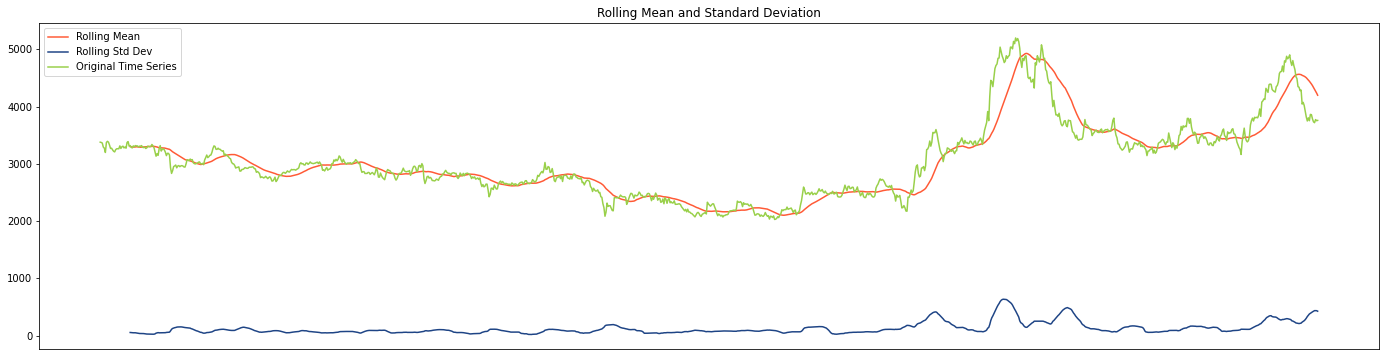

In [70]:
stationarity_test(train_8194['ad_Close'])

In [71]:
#def adf_test():
    

In [72]:
train_8194.columns

Index(['Date', 'SecuritiesCode', 'ExpectedDividend', 'SupervisionFlag',
       'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume', 'ad_Target',
       'ad_Close_lag1', 'ad_Close_sma10', 'logprice_ad_Close',
       'detrend_ad_Close', 'trend_ad_Close', 'season_ad_Close',
       'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10', 'logprice_ad_Open',
       'detrend_ad_Open', 'trend_ad_Open', 'season_ad_Open', 'error_ad_Open',
       'ad_High_lag1', 'ad_High_sma10', 'logprice_ad_High', 'detrend_ad_High',
       'trend_ad_High', 'season_ad_High', 'error_ad_High', 'ad_Low_lag1',
       'ad_Low_sma10', 'logprice_ad_Low', 'detrend_ad_Low', 'trend_ad_Low',
       'season_ad_Low', 'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10',
       'RSI', 'Return', 'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year',
       'week', 'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos', 'Year_sin', 'Year_cos', 'Profit', 'NetSales', 'margin',
       'win_quarter_growth', 'rev_quarter

In [73]:
features_to_use = ['Date','ExpectedDividend', 'SupervisionFlag',
       'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume', 'ad_Target',
       'RSI', 'Return', 'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year',
       'week', 'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos', 'Year_sin', 'Year_cos', 'Profit', 'NetSales', 'margin',
       'win_quarter_growth', 'rev_quarter_growth', 'margin_growth']

In [74]:
test = train_8194[features_to_use]
test = test.set_index('Date').dropna()

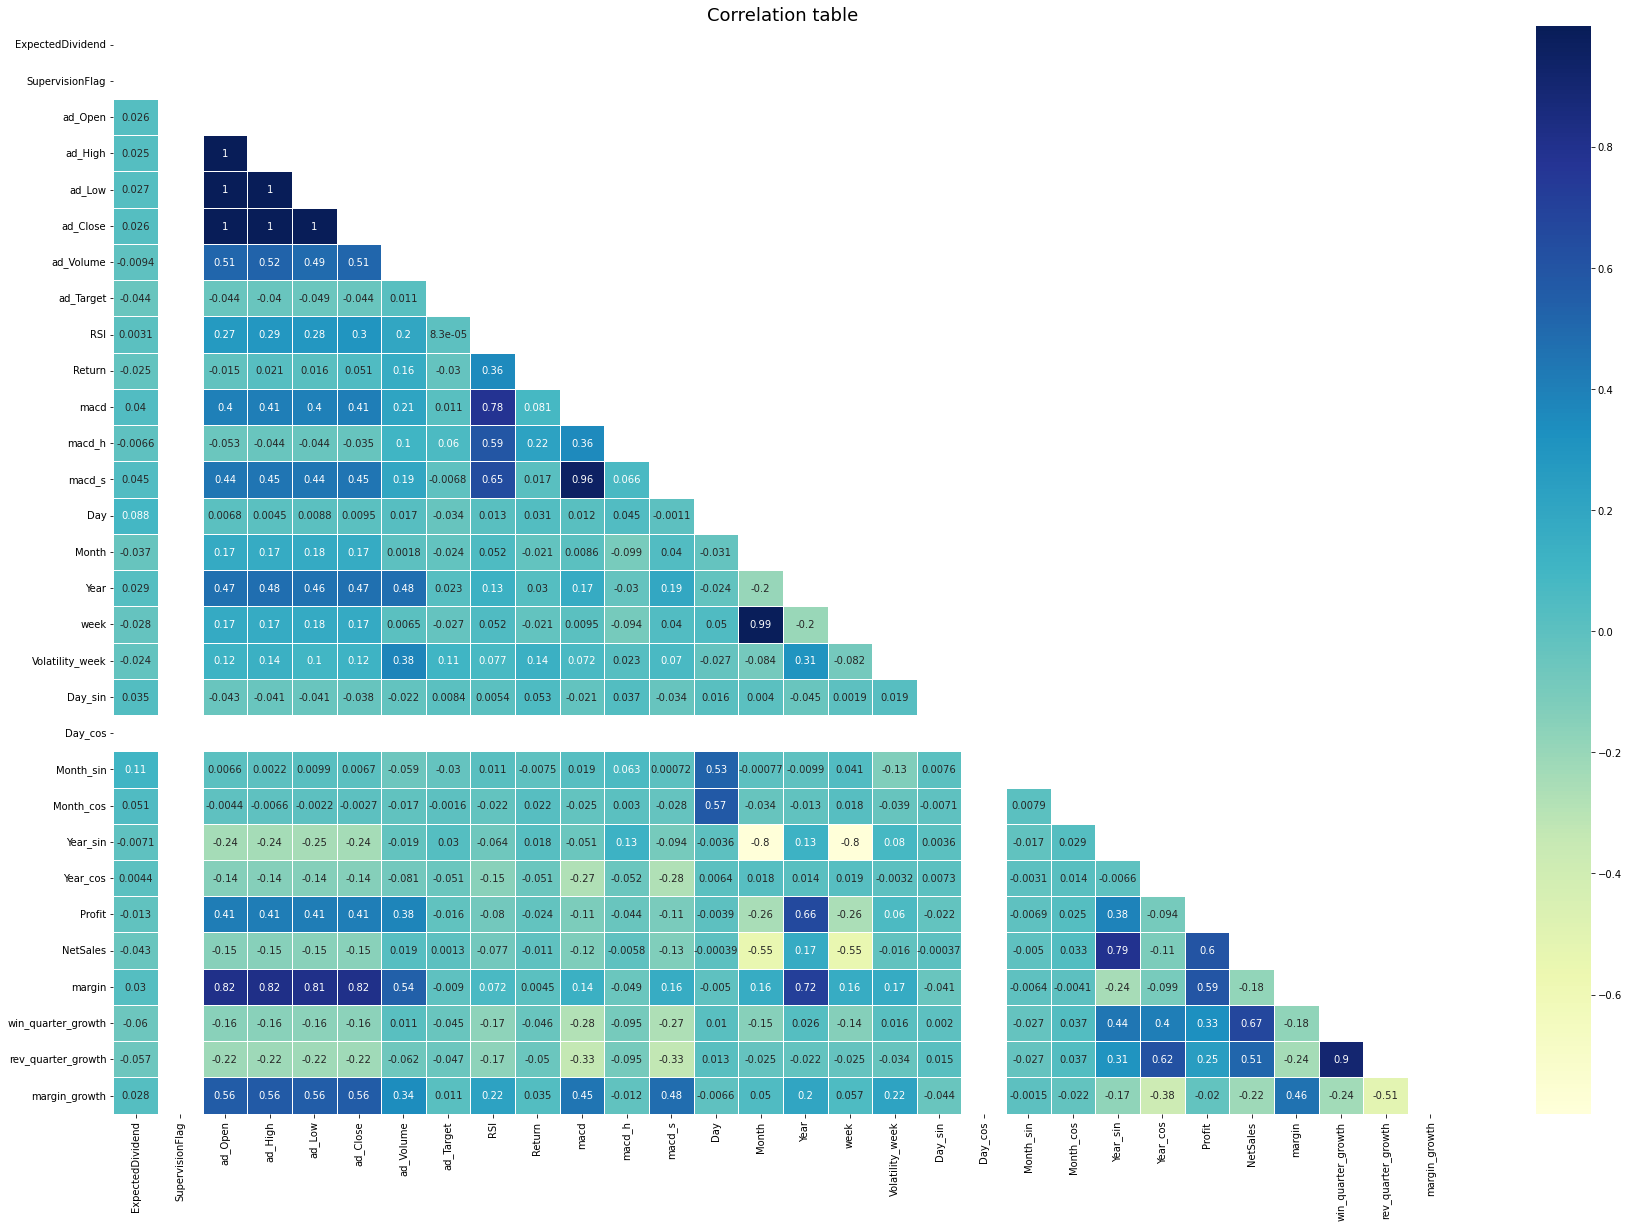

In [75]:
from functions import plot_corr
plot_corr(test, 30,20)

In [76]:
train_data.SecuritiesCode.unique()

array([8194, 8198, 8200, ..., 8179, 8182, 8185])

In [77]:
var_feat = ['Date', 'SecuritiesCode' , 'ad_Close']
var_test = train_data.query('SecuritiesCode == [8194, 8198, 8200]')[var_feat]
var_test = var_test.sort_values('Date').reset_index().drop('index', axis=1)

In [78]:
var_test.head()

,Date,SecuritiesCode,ad_Close
0,2017-01-04,8194,3380.0
1,2017-01-04,8198,1902.0
2,2017-01-04,8200,2298.0
3,2017-01-05,8194,3375.0
4,2017-01-05,8198,1907.0


In [79]:
def transform_Close(df):
    new_df = pd.DataFrame()
    unique_codes = df.SecuritiesCode.unique()

    for day in tqdm(df.Date.unique()):
        curr_day = df.query('Date == @day')
        for i in unique_codes:
            curr_day[f'ad_Close_'+ str(i)] = curr_day.query('SecuritiesCode == @i')['ad_Close']
            curr_day[f'ad_Close_'+ str(i)] = curr_day[f'ad_Close_'+ str(i)].fillna(method='bfill')
            curr_day[f'ad_Close_'+ str(i)] = curr_day[f'ad_Close_'+ str(i)].fillna(method='ffill')     
        new_df = pd.concat([new_df, curr_day])
    new_df.drop(['SecuritiesCode', 'ad_Close'], axis=1, inplace=True)
    new_df.drop_duplicates(inplace=True)
    new_df.set_index('Date', inplace=True)
    return new_df
        

sktime resample von den daten

In [80]:
new_df = transform_Close(var_test)

100%|██████████| 1178/1178 [01:07<00:00, 17.34it/s]


In [81]:
new_df

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2017-01-04,3380.0,1902.0,2298.0
2017-01-05,3375.0,1907.0,2299.0
2017-01-06,3365.0,1905.0,2302.0
2017-01-10,3295.0,1906.0,2323.0
2017-01-11,3275.0,1915.0,2324.0
...,...,...,...
2021-10-22,3735.0,2590.0,2222.0
2021-10-25,3720.0,2593.0,2210.0
2021-10-26,3775.0,2603.0,2183.0


In [82]:
split = -10
train_df = new_df[:split]
test_df = new_df[split:]

In [83]:
test_df.shape

(10, 3)

In [84]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train_df, variables = train_df.columns)   

,ad_Close_8194_x,ad_Close_8198_x,ad_Close_8200_x
ad_Close_8194_y,1.0000,0.0066,0.0003
ad_Close_8198_y,0.0562,1.0000,0.3266
ad_Close_8200_y,0.7245,0.0820,1.0000


In [85]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [86]:
for name, column in new_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ad_Close_8194" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.058
 No. Lags Chosen       = 7
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.2617. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ad_Close_8198" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.488
 No. Lags Chosen       = 18
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.1184. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ad_Close_8200" 
    -----------------------------------------------
 Null Hy

In [87]:
df_differenced = train_df.diff().dropna()

In [88]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ad_Close_8194" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.568
 No. Lags Chosen       = 5
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ad_Close_8198" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9469
 No. Lags Chosen       = 17
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ad_Close_8200" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 S

In [89]:
model = VAR(df_differenced)

In [90]:
model = VAR(df_differenced)

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,21.62,21.63*,2.444e+09,21.62*
1,21.61*,21.66,2.416e+09*,21.63
2,21.61,21.70,2.416e+09,21.64
3,21.61,21.74,2.427e+09,21.66
4,21.61,21.78,2.436e+09,21.68
5,21.62,21.83,2.461e+09,21.70
6,21.63,21.88,2.475e+09,21.72
7,21.64,21.93,2.501e+09,21.75
8,21.65,21.98,2.526e+09,21.77
9,21.64,22.01,2.509e+09,21.78


In [91]:
train_df.head()

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2017-01-04,3380.0,1902.0,2298.0
2017-01-05,3375.0,1907.0,2299.0
2017-01-06,3365.0,1905.0,2302.0
2017-01-10,3295.0,1906.0,2323.0
2017-01-11,3275.0,1915.0,2324.0


In [135]:
var_model = VARMAX(train_df, order=(22,1), enforce_stationarity=True)

model_fitted = var_model.fit(disp=False)
model_fitted.summary()

Dep. Variable:,"['ad_Close_8194', 'ad_Close_8198', 'ad_Close_8200']",No. Observations:,1168
Model:,"VARMA(22,1)",Log Likelihood,-17440.438
,+ intercept,AIC,35312.876
Date:,"Fri, 29 Apr 2022",BIC,36406.494
Time:,09:57:50,HQIC,35725.383
Sample:,0,,
,- 1168,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.03, 0.03, 0.03",Jarque-Bera (JB):,"1413.17, 5485.10, 376.20"
Prob(Q):,"0.86, 0.87, 0.87",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"4.12, 2.29, 1.77",Skew:,"0.79, -0.80, -0.08"


In [139]:
n_forcast = split*(-1)-1
start_point = len(train_df)

pred = model_fitted.get_prediction(start=start_point, end=start_point+n_forcast)

predictions = pred.predicted_mean

predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

In [111]:
# n_forcast = 22
# start_point = test_df.index[1].strftime('%y-%m-%d')
# stop_point = test_df.index[-1].strftime('%y-%m-%d')

# pred = model_fitted.get_prediction(start=start_point, end=stop_point)


In [140]:
predictions = pred.predicted_mean

In [141]:
predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

In [142]:
test_df.head()

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2021-10-15,3805.0,2565.0,2279.0
2021-10-18,3755.0,2576.0,2249.0
2021-10-19,3865.0,2599.0,2221.0
2021-10-20,3860.0,2588.0,2214.0
2021-10-21,3785.0,2585.0,2236.0


In [143]:
predictions

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2021-10-15,3734.790853,2562.773084,2296.039273
2021-10-18,3736.054193,2575.970328,2310.500552
2021-10-19,3724.180399,2574.510986,2298.026225
2021-10-20,3701.722166,2578.103250,2298.905811
2021-10-21,3703.226647,2577.410759,2298.177333
2021-10-22,3716.568176,2590.815552,2299.368055
2021-10-25,3681.596079,2582.612067,2293.199516
2021-10-26,3690.408440,2583.885855,2303.303106
2021-10-27,3692.753771,2595.339167,2294.494904


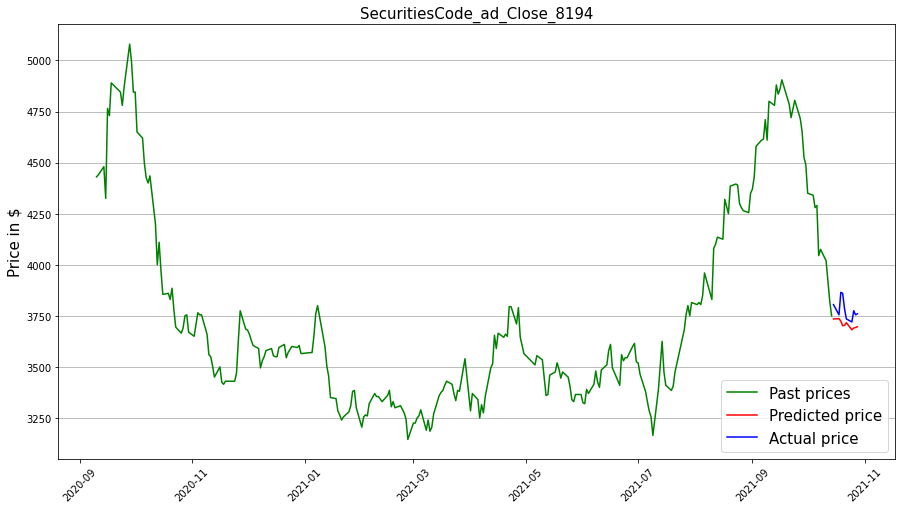

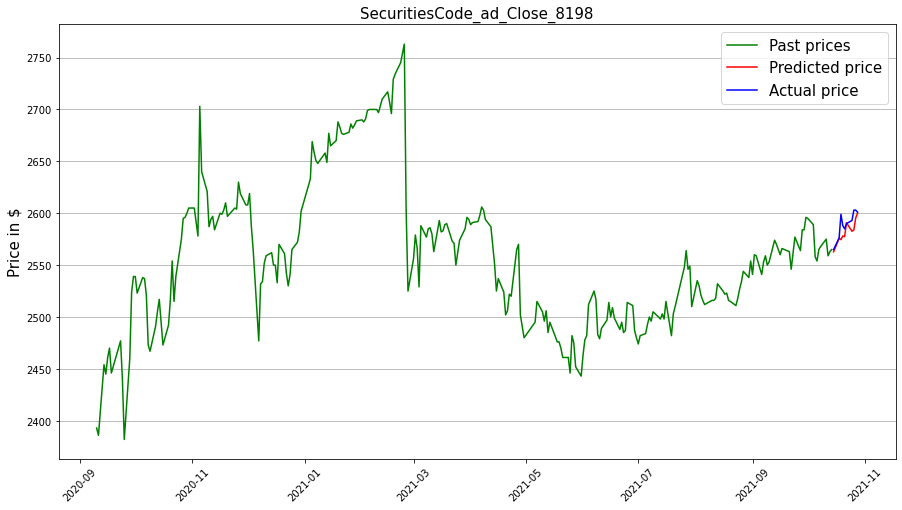

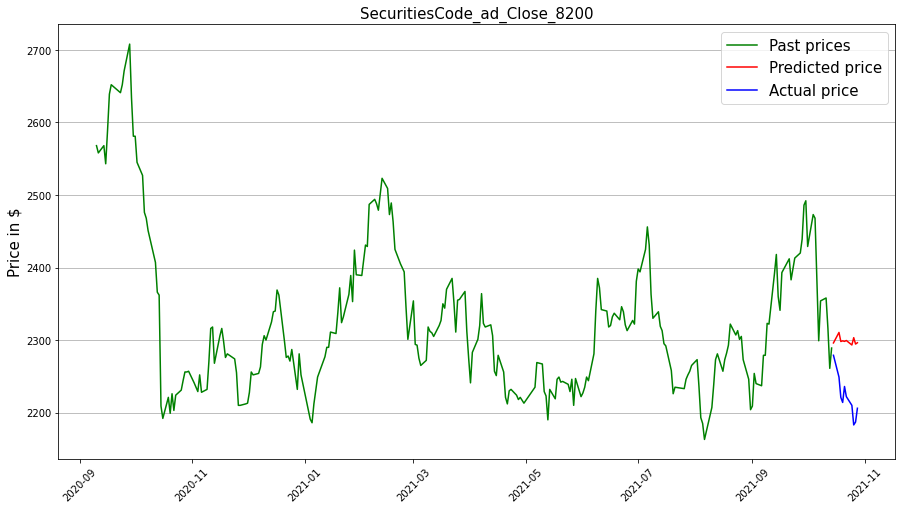

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in predictions.columns:


    plt.figure(figsize=(15,8))

    sns.lineplot(train_df.index[900:], train_df[i][900:], color="green")
    sns.lineplot(predictions.index, predictions[i], color="red")
    sns.lineplot(test_df.index, test_df[i], color="blue")

    plt.ylabel("Price in $",fontsize=15)
    plt.xlabel("",fontsize=1)
    plt.yticks(size = 10)
    plt.xticks(size = 10, rotation = 45)
    plt.title('SecuritiesCode_' + i, fontsize = 15)
    plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
    plt.grid(axis='y')
    plt.show()

var_model = VARMAX(train_df, order=(1,22), enforce_stationarity=True)

model_fitted = var_model.fit(disp=False)
model_fitted.summary()

from sklearn.metrics import mean_squared_error as mse
mse(y_pred=predictions["ad_Close_8198"], y_true=test_df["ad_Close_8198"], squared=False)
-> RMSE 10.75

In [163]:
from sklearn.metrics import mean_squared_error as mse
for i in predictions.columns:
    print(mse(y_pred=predictions[i], y_true=test_df[i], squared=False))

85.86280823462756
11.373516096409734
82.5654039057231


plt_acf -> q </br>
plt_pacf -> p

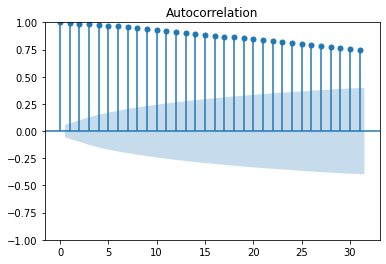

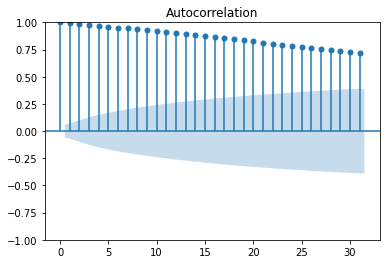

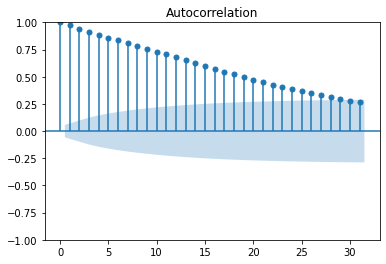

In [117]:
for i in train_df.columns:
    
    plot_acf(train_df[i])

# VAR Model 2

In [207]:
# features_to_use = ['Date', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume',             #'ExpectedDividend', 'SupervisionFlag',
#        'RSI', 'macd', 'macd_s', 'Month', 'Year',
#        'week', 'Volatility_week', 'Year_sin', 'Year_cos', 'Profit', 'NetSales', 'margin',
#        'win_quarter_growth', 'rev_quarter_growth', 'margin_growth']

features_to_use = ['Date', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close','Profit', 'NetSales']

mod2_train_8194 = train_data.query('SecuritiesCode == 8194')[features_to_use].set_index('Date').dropna()
mod2_test_8194 = test_data.query('SecuritiesCode == 8194')[features_to_use].set_index('Date').dropna()


#plot_corr(mod2_train_8194, 30,20)

In [183]:
mod2_train_8194.head()

,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,RSI,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
Date,,,,,,,,,,,,,,,,
2017-04-12,3110.0,3150.0,2929.0,2932.0,65800.0,27.542967,4.0,2017.0,15.0,7.827894,8.110000e+09,6.529740e+11,1.24201,51.50383,34.631594,12.532152
2017-04-13,2880.0,2934.0,2816.0,2834.0,115200.0,23.846127,4.0,2017.0,15.0,7.827894,8.110000e+09,6.529740e+11,1.24201,51.50383,34.631594,12.532152
2017-04-14,2800.0,2895.0,2800.0,2882.0,51700.0,28.881184,4.0,2017.0,15.0,7.827894,8.110000e+09,6.529740e+11,1.24201,51.50383,34.631594,12.532152
2017-04-17,2865.0,2987.0,2865.0,2954.0,33200.0,35.743994,4.0,2017.0,16.0,3.329371,8.110000e+09,6.529740e+11,1.24201,51.50383,34.631594,12.532152
2017-04-18,3005.0,3005.0,2950.0,2965.0,36000.0,36.748229,4.0,2017.0,16.0,3.329371,8.110000e+09,6.529740e+11,1.24201,51.50383,34.631594,12.532152


In [211]:
mod2_train_8194.describe()

,ad_Open,ad_High,ad_Low,ad_Close,Profit,NetSales
count,1173.000000,1173.000000,1173.000000,1173.000000,1.173000e+03,1.173000e+03
mean,3053.402387,3087.164535,3012.877238,3050.227621,6.379148e+09,4.430861e+11
std,667.103063,677.799078,653.543463,666.706814,4.219472e+09,1.972392e+11
min,2020.000000,2048.000000,2000.000000,2030.000000,1.669000e+09,1.676580e+11
25%,2587.000000,2606.000000,2545.000000,2575.000000,2.930000e+09,1.951520e+11
50%,2922.000000,2950.000000,2891.000000,2926.000000,5.446000e+09,4.850080e+11
75%,3380.000000,3410.000000,3330.000000,3370.000000,7.834000e+09,6.529740e+11
max,5200.000000,5220.000000,5120.000000,5200.000000,1.782400e+10,7.591460e+11


In [208]:
df_differenced_mod2 = mod2_train_8194.diff().dropna()

model_2 = VAR(df_differenced_mod2)

x = model_2.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,117.4,117.4,9.278e+50,117.4
1,116.0,116.2,2.501e+50,116.1
2,115.6,115.9*,1.591e+50,115.7
3,115.5,116.0,1.396e+50,115.7
4,115.3,116.0,1.240e+50,115.6
5,115.2,116.1,1.124e+50,115.6*
6,115.2,116.2,1.090e+50,115.6
7,115.2,116.3,1.080e+50,115.6
8,115.2,116.5,1.043e+50,115.7
9,115.1,116.6,1.021e+50,115.7


In [ ]:
for i in mod2_train_8194.columns:
    
    plot_acf(mod2_train_8194[i])

In [213]:
var_model_2 = VARMAX(mod2_train_8194, order=(10,20), enforce_stationarity=True)

model_fitted_2 = var_model_2.fit(disp=False)
model_fitted_2.summary()

LinAlgError: 2-th leading minor of the array is not positive definite

In [181]:
n_forcast = split*(-1)-1
start_point_2 = len(mod2_train_8194)

pred_2 = model_fitted_2.get_prediction(start=start_point_2, end=start_point_2+n_forcast)

predictions_2 = pred_2.predicted_mean

predictions_2 = pd.concat([predictions_2.reset_index(), (mod2_train_8194.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

NameError: name 'model_fitted_2' is not defined